# Keras Model CNN for Classification
## April 8, 2018

In [123]:
import tensorflow
import keras
import numpy as np
import pandas as pd

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Conv1D, MaxPooling1D , Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.core import Flatten
from keras.models import Sequential
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint

from keras.utils import to_categorical

%matplotlib inline

## Data Preprocessing

In [3]:
data = pd.read_csv('../../../Comments_FanofGame_data_bandwagon.csv')

In [4]:
# pd.options.display.max_colwidth = 10000
data = data[data.comment_body.notnull()]
data = data[data.comment_body!='[removed]']
data = data[data.comment_body!='[deleted]']
data = data[~data.comment_body.str.contains("\^This \^message \^was \^created \^by \^a \^bot")]
data = data[~data.comment_body.str.contains("\*\*Please review the rules for")]

# Remove Superbowl Threads
data = data[
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3)') &
(data.submission_title!='Super Bowl LII Game Thread: Philadelphia Eagles (15-3) at New England Patriots (15-3) (Second Half)') &
(data.submission_title!='Super Bowl 51 Pre Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)') &
(data.submission_title!='Super Bowl 51 Post Game Thread: New England Patriots (14-2) at Atlanta Falcons (11-5)')
]

In [127]:
labels = data['fan_of_team_playing'].values
docs = data['comment_body'].values

vocab_size = 100000
encoded_docs = [one_hot(str(d), vocab_size) for d in docs]

In [128]:
np.mean(labels)

0.4743333871689441

In [129]:
# pad documents to a max length of 500 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

## Create Model

In [130]:
num_filters = 5
dropout=0.5
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Conv1D(num_filters,1,activation='tanh'))
model.add(MaxPooling1D(pool_size=(3,),strides=1))
model.add(Dropout(dropout))
model.add(Conv1D(num_filters*2,2,activation='relu'))
model.add(MaxPooling1D(pool_size=(2,),strides=1))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(256,activation='tanh'))
model.add(Dropout(dropout))
model.add(Dense(128,activation='tanh'))
model.add(Dense(2,activation='softmax'))
#model.add(Activation('softmax'))
#model.compile(loss=keras.losses.categorical_crossentropy,optimzer=keras.optimizers.SGD(),metrics=['accuracy'])
adam = Adam(lr=0.0001, decay=1e-5)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['mse', 'acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 8)            800000    
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 100, 5)            45        
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 98, 5)             0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 98, 5)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 97, 10)            110       
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 96, 10)            0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 96, 10)            0         
__________

In [131]:
# checkpoint for periodically saving model
filepath="weights-improvement-april8-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

y_binary = to_categorical(labels)

# fit the model
model.fit(padded_docs, y_binary, epochs=25, verbose=1, validation_split=0.15, callbacks=callbacks_list)

Train on 1605195 samples, validate on 283270 samples
Epoch 1/25
1605195/1605195 [==============================] - 558s 348us/step - loss: 0.6683 - mean_squared_error: 0.2378 - acc: 0.5841 - val_loss: 0.6708 - val_mean_squared_error: 0.2391 - val_acc: 0.5762

Epoch 00001: saving model to weights-improvement-april8-01-0.58.hdf5
Epoch 2/25
1605195/1605195 [==============================] - 579s 361us/step - loss: 0.6558 - mean_squared_error: 0.2320 - acc: 0.6061 - val_loss: 0.6678 - val_mean_squared_error: 0.2377 - val_acc: 0.5816

Epoch 00002: saving model to weights-improvement-april8-02-0.58.hdf5
Epoch 3/25
1605195/1605195 [==============================] - 565s 352us/step - loss: 0.6522 - mean_squared_error: 0.2303 - acc: 0.6117 - val_loss: 0.6676 - val_mean_squared_error: 0.2376 - val_acc: 0.5868

Epoch 00003: saving model to weights-improvement-april8-03-0.59.hdf5
Epoch 4/25
1605195/1605195 [==============================] - 562s 350us/step - loss: 0.6501 - mean_squared_error: 0.22

# Predict On Dataset using Model
- Identify Documents it predicted well and poorly

In [132]:
# Make predictions on the same dataset
predict_prob = model.predict(padded_docs)
predictions = model.predict(padded_docs)

In [183]:
# Save the predictions alongside the comments in a dataframe
model_preds = pd.DataFrame(index=docs)
model_preds['predicted_class'] = 0
model_preds['predicted_class'] = predictions
# Predicted class is actually the inverse (I think)
model_preds['predicted_class'] = 1 - model_preds['predicted_class']
model_preds['actual_class'] = labels
model_preds['prob_off'] = abs(model_preds['predicted_class'] - model_preds['actual_class'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6d1580ab38>,
      dtype=object)

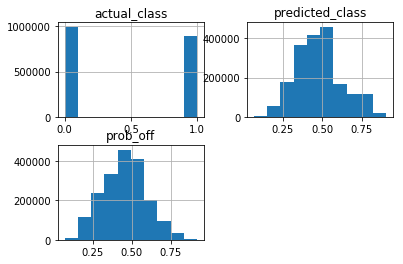

In [188]:
# Plot to see the distribution of the errors
model_preds.hist()

In [191]:
# Example of a well predicted comment of a non-fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][0]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][0]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[0])

-------------------------
----predicted as: 0.06995964050292969
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
**Fencing response**

The fencing response is a peculiar position of the arms following a concussion. Immediately after moderate forces have been applied to the brainstem, the forearms are held flexed or extended (typically into the air) for a period lasting up to several seconds after the impact. The fencing response is often observed during athletic competition involving contact, such as American football, hockey, rugby and martial arts. It is used as an overt indicator of injury force magnitude and midbrain localization to aid in injury identification and classification for events including, but not limited to, on-field and/or bystander observations of sports-related head injuries.

***

^[ [^PM](https://www.reddit.com/message/compose?to=kittens_from_space) ^| [^Exclude ^me](https://reddit.com/message/compose?to=WikiTextBot&message=Excludeme&subj

In [206]:
# Example of a well predicted comment of a fan



print('-------------------------')
print('----predicted as: {}'.format(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off')['predicted_class'][2]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off')['actual_class'][2]))
print('-------comment-----------')
print(model_preds.loc[model_preds['actual_class'] == 1].sort_values('prob_off').index[2])

-------------------------
----predicted as: 0.9008954763412476
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
Our only starting OL is our LT. Our ILB medically retired, we don't have our 1st, 2nd, 3rd, WR, our three starting RBs and our breakout CB last year in Tavon Young. Our other CB Hill who showed out in preseason is hurt. Our 2nd and 3rd TE are out. We have 20 on IR. 

We are 3-3, tied 6-6 with Sota and one game out of 1st in our division with 2 division wins. 


In [211]:
# Example of a poorly predicted comment of a non-fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-1]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-1]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-1])

-------------------------
----predicted as: 0.0809553861618042
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
What...what do you mean?  

Edit:  I'll attempt to answer.

> *How* is New England the 1 seed in the AFC?

New England is the 1 seed because they beat the Pittsburgh Steelers to take first seed, due to tiebreaker going to the Pats due to the win.  

> How is *New England* the 1 seed in the AFC?

They went 4-2 in their first 6 games of the season, arguably the hardest games on the schedule.  They finish off the season with mostly divisional matchups, for which they are currently 4-1 in.  

> How is New England the *1* seed in the AFC?

Tiebreaker over Pittsburgh.  

> How is New England the 1 seed in the *AFC*?

The Patriots play in the AFC.  


In [217]:
# Example of a poorly predicted comment of a fan
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-10]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-10]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-10])

-------------------------
----predicted as: 0.0934571623802185
----actually: 1---(1 = fan, 0 = not fan --------
-------comment-----------
In the lead-up to the eclipse, I read a lot about the damage you could do to your eyes by looking at it without the proper protective glasses on. They said optomotrists would be able to tell you looked at the sun, because the outline of the eclipse would be burned into the cornea. For the rest of your life, that image is literally burned into your eye. It never goes away. It never heals. The damage is permanent.

If you look into my eyes, you can see the outline of the David Tyree helmet catch. It never goes away. It never heals. The damage is permanent.

I wish you the best this season, my friend.


In [233]:
# Example of a poorly predicted comment of a non-fan
# They actually sound like a fan - probably mislabeled
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-21]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-21]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-21])

-------------------------
----predicted as: 0.8980789184570312
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
the biggest problem is injuries and in a close second our pass blocking. if we were healthy and our pass blocking was competent our pass heavy offense would work but eli has had 2 seconds to throw the ball and has made bad throws with players wide open. you can definitely say our defense has still been good regardless of the shit show our offense has been and that is without our best coverage LB and last game without our MLB and Jackrabbit.  


In [237]:
# Example of a poorly predicted comment of a non-fan
# They actually sound like a fan too! Probably mislabeled
print('-------------------------')
print('----predicted as: {}'.format(model_preds.sort_values('prob_off')['predicted_class'][-29]))
print('----actually: {}---(1 = fan, 0 = not fan --------'.format(model_preds.sort_values('prob_off')['actual_class'][-29]))
print('-------comment-----------')
print(model_preds.sort_values('prob_off').index[-29])

-------------------------
----predicted as: 0.8941841125488281
----actually: 0---(1 = fan, 0 = not fan --------
-------comment-----------
There defense has only allowed one team to score 20 points and in the 4th quarter the offense tends to get their head out of their asses. Our offense is 32nd in the league and the defense has the ability to be top 10. Our oline is killing us. Our LT is hurt and we are missing both of our starting guards. It's bad


# Use the model to predict some test cases

In [243]:
tests = ['we are awesome',
         'our team is awesome',
         'jags suck',
         'when will we win',
         'we are so dumb',
         'they suck',
         'why arent we winning',
        'this is hilarious',
        'just tuned in',
        'rigged refs',
        'i hate football',
        'i love football',
        'that was a horrible call',
        'we are so good',
        'they',
        'we',
        'tom brady is so good that they dont know what to do with him',
        'I love Lions fans cause we can drink bleach together this christmas eve']
encoded_test = [one_hot(str(d), vocab_size) for d in tests]
padded_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')
preds_test = model.predict(padded_test)

In [244]:
test_results = pd.DataFrame(index=tests)
test_results['prediction'] = 0
test_results['prediction'] = preds_test
# Predicted class is actually the inverse (I think)
test_results['prediction'] = 1 - test_results['prediction']
test_results

,prediction
we are awesome,0.647458
our team is awesome,0.767350
jags suck,0.232012
when will we win,0.749833
we are so dumb,0.714126
they suck,0.451200
why arent we winning,0.752060
this is hilarious,0.378172
just tuned in,0.209693
rigged refs,0.468423
